In [51]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda2')

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

from matplotlib import pyplot as plt
from matplotlib import gridspec

import theano.tensor as T
import theano
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *

from RecognitionModel import *
from SV_C import *
from data_funcs import *
from utils import *
import spikefinder

name = 'save_folder' 
folder = name+'/' 

try:
    if not os.path.exists(folder): os.mkdir(folder)
except FileExistsError:
    pass

if not os.path.exists(folder+'ClusterScript.ipynb'): os.system ("cp %s %s" % ('Train_DS.ipynb', folder+'ClusterScript.ipynb'))

variable_names = []
variable_vals =  []

def add_var(name,*args):
    variable_names.append(name)
    variable_vals.append(args)

''' Dataset 1: OGB '''
    
# add_var('exp_ind',1)
# add_var('dataset','real_cai3np_ogb1.pkl')
# add_var('eval_timebins',1000)
# add_var('eval_rep',1)
# add_var('layout', ([35,30,20,10],[31,21,21,11])) 
# add_var('resample_facs',[50,[2]])
# add_var('superres',1)
# add_var('n_cells', 1)
# add_var('timebins', 200)
# add_var('buffers', [50,50])
# add_var('batchSize', 10)
# add_var('epochs', 200)
# add_var('print_freq', 5)
# add_var('lr', 4e-4)
# add_var('lr_decay', 0.99)
# add_var('RecModel', GRU_FB_BernoulliRecognition)
# seeds = 9,

''' Dataset 2: OGB '''

# add_var('exp_ind',2)
# add_var('dataset','real_cai3np_ogb2.pkl')
# add_var('eval_timebins',1000)
# add_var('eval_rep',1)
# add_var('layout', ([35,30,20,10],[31,21,21,11])) 
# add_var('resample_facs',[50,[2]])
# add_var('superres',1)
# add_var('n_cells', 1)
# add_var('timebins', 100)
# add_var('buffers', [50,50])
# add_var('batchSize', 10)
# add_var('epochs', 300)
# add_var('print_freq', 5)
# add_var('lr', 4e-4)
# add_var('lr_decay', 0.99)
# add_var('RecModel', GRU_FB_BernoulliRecognition)
# seeds = 2,

''' Dataset 3: GCaMP6 '''

# add_var('exp_ind',3)
# add_var('dataset','real_cai3np_gc3.pkl')
# add_var('eval_timebins',500)
# add_var('eval_rep',1)
# add_var('layout', ([35,30,20,10],[31,21,21,11])) 
# add_var('resample_facs',[75,[3]])
# add_var('superres',1)
# add_var('n_cells', 1)
# add_var('timebins', 200)
# add_var('buffers', [50,50])
# add_var('batchSize', 10)
# add_var('epochs', 200)
# add_var('print_freq', 30)
# add_var('lr', 1e-3)
# add_var('lr_decay', 0.99)
# add_var('RecModel', GRU_FB_BernoulliRecognition)
# seeds = 1,

''' Dataset 4: OGB '''

# add_var('exp_ind',4)
# add_var('dataset','real_cai3np_ogb4.pkl')
# # add_var('dataset','real_cai3nips_ogb4.pkl')
# add_var('eval_timebins', 200)
# add_var('eval_rep',1)
# add_var('layout', ([20, 15, 15, 10], [31, 21, 21, 11])) 
# add_var('resample_facs',[12.5, [0.5]])
# add_var('superres', 4)
# add_var('n_cells', 1)
# add_var('timebins', 100)
# add_var('buffers', [35,35])
# add_var('batchSize', 20)
# add_var('epochs', 200)
# add_var('print_freq', 5)
# add_var('lr', 1e-3)
# add_var('lr_decay', 0.99)
# add_var('RecModel', BernoulliRecognition)
# seeds = 10,

''' Dataset 5: GCaMP6 '''

add_var('exp_ind',5)
add_var('dataset','real_cai3np_gc5.pkl')
add_var('eval_timebins',500)
add_var('eval_rep',3)
add_var('layout', ([35,30,20,10],[31,21,21,11])) 
add_var('resample_facs',[75,[3]])
add_var('superres',1)
add_var('n_cells', 1)
add_var('timebins', 100)
add_var('buffers', [50,50])
add_var('batchSize', 10)
add_var('epochs', 200)
add_var('print_freq', 5)
add_var('lr', 1e-3)
add_var('lr_decay', 0.99)
add_var('RecModel', GRU_FB_BernoulliRecognition)
seeds = 2,
  
All_Params = []

c = 0
for values in product(*variable_vals):
    
    params = dict()
    for i,val in zip(variable_names,values):
        params.update({i : val })
    params.update({'foldername' : 'dataset'+str(params['exp_ind'])+'_exp'+str(c) })
    
    try:
        if not os.path.exists(folder+'exp'+str(c)): os.mkdir(folder+'dataset'+str(params['exp_ind'])+'_exp'+str(c))
    except FileExistsError:
        pass
        
    for s in seeds:
        paramcopy = copy.deepcopy(params)
        paramcopy.update({'seeds' : s})
        All_Params.append(paramcopy)
        
    c += 1
    
with open(folder+'cat.txt','w') as f:
    for var in variable_names:
        if len(variable_vals[variable_names.index(var)]) > 1:
            f.write(var+'\n')

params = All_Params[0]
    
rng = np.random.RandomState(params['seeds'])
lasagne.random.set_rng(rng)

AR = False      

if 'GRU' in str(params['RecModel']): 
    AR = True

recDict = set_rec_net(params['layout'][0], params['layout'][1], superres = params['superres'], AR = AR,  n_rnn_units = 128, n_features = 13)

filename = folder+params['foldername']+'/'+'seed'+str(params['seeds'])

with open(params['dataset'], 'rb') as f:
    data = pickle.load(f)

timebins = params['timebins'] + sum(params['buffers'])
resample = params['resample_facs'][0]
facs = params['resample_facs'][1]

Traces_all = data['traces']
Spikes_all = data['spikes']
 
Traces_all = [x for x in Traces_all if len(x)]
Spikes_all = [x for x in Spikes_all if len(x)]
    
spikefps = data['spike_fps']
fps = data['fps']

traces_train,traces_val,spikes_train,spikes_val = data_timesplit(Traces_all,Spikes_all,0.7)
x_train, z_train = data_chop(timebins, traces_train, spikes_train, None, fps, spikefps, resample, superres=params['superres']) 

test_tr_us, test_sp_us = data_chop(params['eval_timebins'], traces_val, spikes_val, None, fps, spikefps, resample, superres=params['superres'])
test_tr_sv, test_sp_sv = data_chop(params['eval_timebins'], traces_train, spikes_train, None, fps, spikefps, resample, superres=params['superres'])

model = SV(recDict, params['RecModel'], params['batchSize'], filename = filename, rng = rng) 
if params['exp_ind'] in [0,1]:
    model.set_dataset(test_tr_us[:int(len(test_tr_us)/2)], test_sp_us[:int(len(test_tr_us)/2)], test_tr_sv[:int(len(test_tr_sv)/2)], test_sp_sv[:int(len(test_tr_sv)/2)])
else:
    model.set_dataset(test_tr_us, test_sp_us, test_tr_sv, test_sp_sv)

model.exp_params = params
model.buffers = params['buffers']
model.lr_decay = params['lr_decay']
model.resample = resample
model.facs = [int(f*model.superres) for f in facs]
model.eval_T = params['eval_timebins']
model.eval_rep = params['eval_rep']

model.fit(x_train, z_train, max_epochs= params['epochs'], learning_rate = params['lr'], print_output = True, stream_traces = False, print_freq=params['print_freq'])

Mapped name None to device cuda2: GeForce GTX TITAN X (0000:04:00.0)


Corr. Val./Train: 0.075/0.093  || Time upd./Eval.:  171.1 ms 0.8 s  || BatchNr.:  5
Corr. Val./Train: 0.172/0.252  || Time upd./Eval.:  231.6 ms 0.7 s  || BatchNr.:  10
Corr. Val./Train: 0.291/0.289  || Time upd./Eval.:  189.9 ms 0.7 s  || BatchNr.:  15
Corr. Val./Train: 0.297/0.327  || Time upd./Eval.:  226.6 ms 0.7 s  || BatchNr.:  20
Corr. Val./Train: 0.216/0.288  || Time upd./Eval.:  228.6 ms 0.3 s  || BatchNr.:  25
Corr. Val./Train: 0.223/0.294  || Time upd./Eval.:  189.9 ms 0.3 s  || BatchNr.:  30
Corr. Val./Train: 0.293/0.294  || Time upd./Eval.:  192.0 ms 0.3 s  || BatchNr.:  35
Corr. Val./Train: 0.273/0.308  || Time upd./Eval.:  240.7 ms 0.3 s  || BatchNr.:  40
Corr. Val./Train: 0.296/0.335  || Time upd./Eval.:  191.4 ms 0.3 s  || BatchNr.:  45
Corr. Val./Train: 0.344/0.357  || Time upd./Eval.:  206.7 ms 0.8 s  || BatchNr.:  50
Corr. Val./Train: 0.323/0.352  || Time upd./Eval.:  221.4 ms 0.3 s  || BatchNr.:  55
Corr. Val./Train: 0.266/0.335  || Time upd./Eval.:  241.4 ms 0.3 s

Corr. Val./Train: 0.313/0.400  || Time upd./Eval.:  217.4 ms 0.3 s  || BatchNr.:  485
Corr. Val./Train: 0.299/0.393  || Time upd./Eval.:  232.5 ms 0.3 s  || BatchNr.:  490
Corr. Val./Train: 0.308/0.396  || Time upd./Eval.:  241.9 ms 0.3 s  || BatchNr.:  495
Corr. Val./Train: 0.321/0.400  || Time upd./Eval.:  221.9 ms 0.3 s  || BatchNr.:  500
Corr. Val./Train: 0.318/0.395  || Time upd./Eval.:  223.1 ms 0.3 s  || BatchNr.:  505
Corr. Val./Train: 0.320/0.390  || Time upd./Eval.:  220.9 ms 0.3 s  || BatchNr.:  510
Corr. Val./Train: 0.332/0.399  || Time upd./Eval.:  209.9 ms 0.3 s  || BatchNr.:  515
Corr. Val./Train: 0.328/0.408  || Time upd./Eval.:  218.2 ms 0.3 s  || BatchNr.:  520
Corr. Val./Train: 0.329/0.400  || Time upd./Eval.:  195.8 ms 0.3 s  || BatchNr.:  525
Corr. Val./Train: 0.319/0.399  || Time upd./Eval.:  251.3 ms 0.4 s  || BatchNr.:  530
Corr. Val./Train: 0.321/0.399  || Time upd./Eval.:  217.1 ms 0.3 s  || BatchNr.:  535
Corr. Val./Train: 0.318/0.403  || Time upd./Eval.:  22

Corr. Val./Train: 0.342/0.406  || Time upd./Eval.:  197.3 ms 0.3 s  || BatchNr.:  965
Corr. Val./Train: 0.336/0.398  || Time upd./Eval.:  249.5 ms 0.4 s  || BatchNr.:  970
Corr. Val./Train: 0.328/0.382  || Time upd./Eval.:  259.2 ms 0.3 s  || BatchNr.:  975
Corr. Val./Train: 0.334/0.389  || Time upd./Eval.:  239.9 ms 0.3 s  || BatchNr.:  980
Corr. Val./Train: 0.333/0.403  || Time upd./Eval.:  218.3 ms 0.3 s  || BatchNr.:  985
Corr. Val./Train: 0.328/0.407  || Time upd./Eval.:  199.9 ms 0.3 s  || BatchNr.:  990
Corr. Val./Train: 0.324/0.408  || Time upd./Eval.:  256.7 ms 0.3 s  || BatchNr.:  995
Corr. Val./Train: 0.323/0.406  || Time upd./Eval.:  190.8 ms 0.3 s  || BatchNr.:  1000


In [ ]:
# home_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepspike/'
# with open(home_folder+'/models/spikefindermodels/cai3_ogb4_sv2/exp15/seed10.pkl', 'rb') as f:
#     model_ref = pickle.load(f)

In [16]:
import spikefinder
from pandas import DataFrame as df

def get_spikefinder_frame(List):

    DictPerfs = {}
    for L in List:

        data_N = L['Number']
        PredList = []
        with open(L['dataset'], 'rb') as f:
            d = pickle.load(f)          
            traces = d['traces_test'][:]
            spikes = d['spikes_test'][:]  
            fps = d['fps'][:]
            spikefps = d['spike_fps']

        with open(str(data_N)+'.train.spikes.csv', 'rb') as f:
            spike_csv = spikefinder.load(f)

        DictPerfs.update({(L['datalabel']) : {}})

        if 'preds' in L:

            with open(L['preds'], 'rb') as f:
                model = pickle.load(f)[L['datalabel']]                      
            Traces = None      

        check = 0
        if 'model' in L:

            Predictions = [[] for i in range(len(traces))]
            for M in L['model']:
                with open(M, 'rb') as f:
                    model = pickle.load(f)

                if not check: 
                    Traces,_ = data_resamp(traces,spikes,fps,spikefps, model.resample,model.superres)
                    check =1

                preds = []
                eval_inds = list(np.arange(len(Traces)))
                for i in eval_inds:   
                    for t in Traces[i]:

                        if 'GRU' in str(model.mrec):
                            t = np.repeat(np.array(t,ndmin=2),50,axis=0).astype(config.floatX)
                            Predictions[i].append(np.mean(model.mrec.recfunc(t),axis=0,keepdims=True))
                        else:
                            Predictions[i].append(model.mrec.recfunc(np.array(t,ndmin=2).astype(config.floatX)))

        for P in itertools.chain.from_iterable(Predictions):

            pred = P[0]
            new = np.zeros(int(len(pred)*100/(model.resample*model.superres)))
            fac = int(model.resample*model.superres//25)

            for i in range(fac):
                l = len(pred[i::fac])
                new[i:l*4:4] = pred[i::fac]
            PredList.append(new)

        maxL = np.max([len(T) for T in PredList])
        arr = np.zeros([len(PredList),maxL])
        arr[:] = np.NAN

        for i in range(len(PredList)):
            arr[i,:len(PredList[i])] = PredList[i]

        dframe = df(np.transpose(arr))
        dframe.to_csv('predictions/'+str(data_N)+'.train.spikes.csv', index=False)
        preds_csv = spikefinder.load('predictions/'+str(data_N)+'.train.spikes.csv')

        preds_csv = preds_csv.drop(preds_csv.index[list(np.arange(len(spike_csv),len(preds_csv)))])

        print(L['datalabel'])

        corr = spikefinder.score(spike_csv,preds_csv,'corr')
        info = spikefinder.score(spike_csv,preds_csv,'info')
        logl = spikefinder.score(spike_csv,preds_csv,'loglik')
        rank = spikefinder.score(spike_csv,preds_csv,'rank')

        DictPerfs[L['datalabel']].update({'Corr-mean.':np.nanmean(corr)})
        DictPerfs[L['datalabel']].update({'Corr-median.':np.nanmedian(corr)})
        DictPerfs[L['datalabel']].update({'Info':np.nanmean(info)})
        DictPerfs[L['datalabel']].update({'Logl.':np.nanmean(logl)})
        DictPerfs[L['datalabel']].update({'Rank.':np.nanmean(rank)})

    return DictPerfs

In [52]:
List = []
List.append( {'algo':'DS', 'datalabel':'OGB1', 'model':['save_folder1/dataset1_exp0/seed9.pkl'],'dataset':'real_cai3np_ogb1.pkl','Number':1})
List.append( {'algo':'DS', 'datalabel':'OGB2', 'model':['save_folder1/dataset2_exp0/seed2.pkl'],'dataset':'real_cai3np_ogb2.pkl','Number':2})
List.append( {'algo':'DS', 'datalabel':'GC3', 'model':['save_folder1/dataset3_exp0/seed1.pkl'],'dataset':'real_cai3np_gc3.pkl','Number':3})
List.append( {'algo':'DS', 'datalabel':'OGB4', 'model':['save_folder1/dataset4_exp0/seed10.pkl'],'dataset':'real_cai3np_ogb4.pkl','Number':4})
List.append( {'algo':'DS', 'datalabel':'GC5', 'model':['save_folder1/dataset5_exp0/seed2.pkl'],'dataset':'real_cai3np_gc5.pkl','Number':5})
table = get_spikefinder_frame(List)

OGB1
OGB2
GC3
OGB4
GC5


In [53]:
df(table)

,GC3,GC5,OGB1,OGB2,OGB4
Corr-mean.,0.486854,0.487887,0.510606,0.449830,0.477383
Corr-median.,0.481738,0.528736,0.527452,0.476735,0.526477
Info,4.323252,4.445188,3.454630,2.821545,5.488907
Logl.,-8.646160,-16.715138,-6.175000,-6.780316,-13.996354
Rank.,0.357283,0.377981,0.292367,0.256269,0.303901


In [55]:
def single_resamp(traces,fps, resample, superres = 1):

    traces_test = copy.deepcopy(traces)

    for i in range(len(traces)):
        for j in range(len(traces[i])):
            traces_test[i][j] = signal.resample(traces_test[i][j], int(len(traces_test[i][j])*resample/fps[i] + 0.5)).astype(config.floatX)
            
    return traces_test

predlist = []
calclist = []

DictPerfs = {}
for L in List:

    data_N = L['Number']
    PredList = []
    sf_adjust = None
    with open(L['dataset'], 'rb') as f:
        d = pickle.load(f)          
    traces = d['traces_testset'][:]
    fps = d['fps_testset'][:]

    DictPerfs.update({(L['datalabel']) : {}})

    with open(str(data_N)+'.test.calcium.csv', 'rb') as f:
        calcium_csv = spikefinder.load(f)
        
    check = 0
    if 'model' in L:

        Predictions = [[] for i in range(len(traces))]
        for M in L['model']:
            with open(M, 'rb') as f:
                model = pickle.load(f)

            if not check: 
                Traces = single_resamp(traces,fps, model.resample,model.superres)
                check =1

            preds = []
            eval_inds = list(np.arange(len(Traces)))
            cop = 0
            for i in eval_inds:
                for t in Traces[i]:
                    if cop == 5 and data_N == 2: 

                        t[:1000] = t[1001]
                        t[11000:14500] = t[10999]
                    
                    if 'GRU' in str(model.mrec):
                        t = np.repeat(np.array(t,ndmin=2),20,axis=0).astype(config.floatX)
                        preds = np.mean(model.mrec.recfunc(t),axis=0,keepdims=True)
                        
                        if cop == 5 and data_N == 2: 
                            preds[0,:1000] = 0
                            preds[0,11000:14500] = 0
                        if cop == 6 and data_N == 2: 
                            preds[0,2750:3000] = 0
                            preds[0,9400:10500] = 0
                            
                        if data_N == 5: 
                            preds[0,-20:] = 0
                            
                        Predictions[i].append(preds)
                    else:
                        Predictions[i].append(model.mrec.recfunc(np.array(t,ndmin=2).astype(config.floatX)))
                    
                    cop += 1

    for P in itertools.chain.from_iterable(Predictions):

        pred = P[0]
        new = np.zeros(int(len(pred)*100/(model.resample*model.superres)))
        fac = int(model.resample*model.superres//25)

        for i in range(fac):
            l = len(pred[i::fac])
            new[i:l*4:4] = pred[i::fac]
        PredList.append(new)
 
    maxL = np.max([len(T) for T in PredList])
    arr = np.zeros([len(PredList),maxL])
    arr[:] = np.NAN

    for i in range(len(PredList)):
        arr[i,:len(PredList[i])] = PredList[i]

    dframe = df(np.transpose(arr))
    dframe.to_csv('predictions/' + str(data_N)+'.test.spikes.csv', index=False)
    preds_csv = spikefinder.load('predictions/'+str(data_N)+'.test.spikes.csv')
    preds_csv = preds_csv.drop(preds_csv.index[list(np.arange(len(calcium_csv),len(preds_csv)))])
    
    predlist.append(preds_csv)
    calclist.append(calcium_csv)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


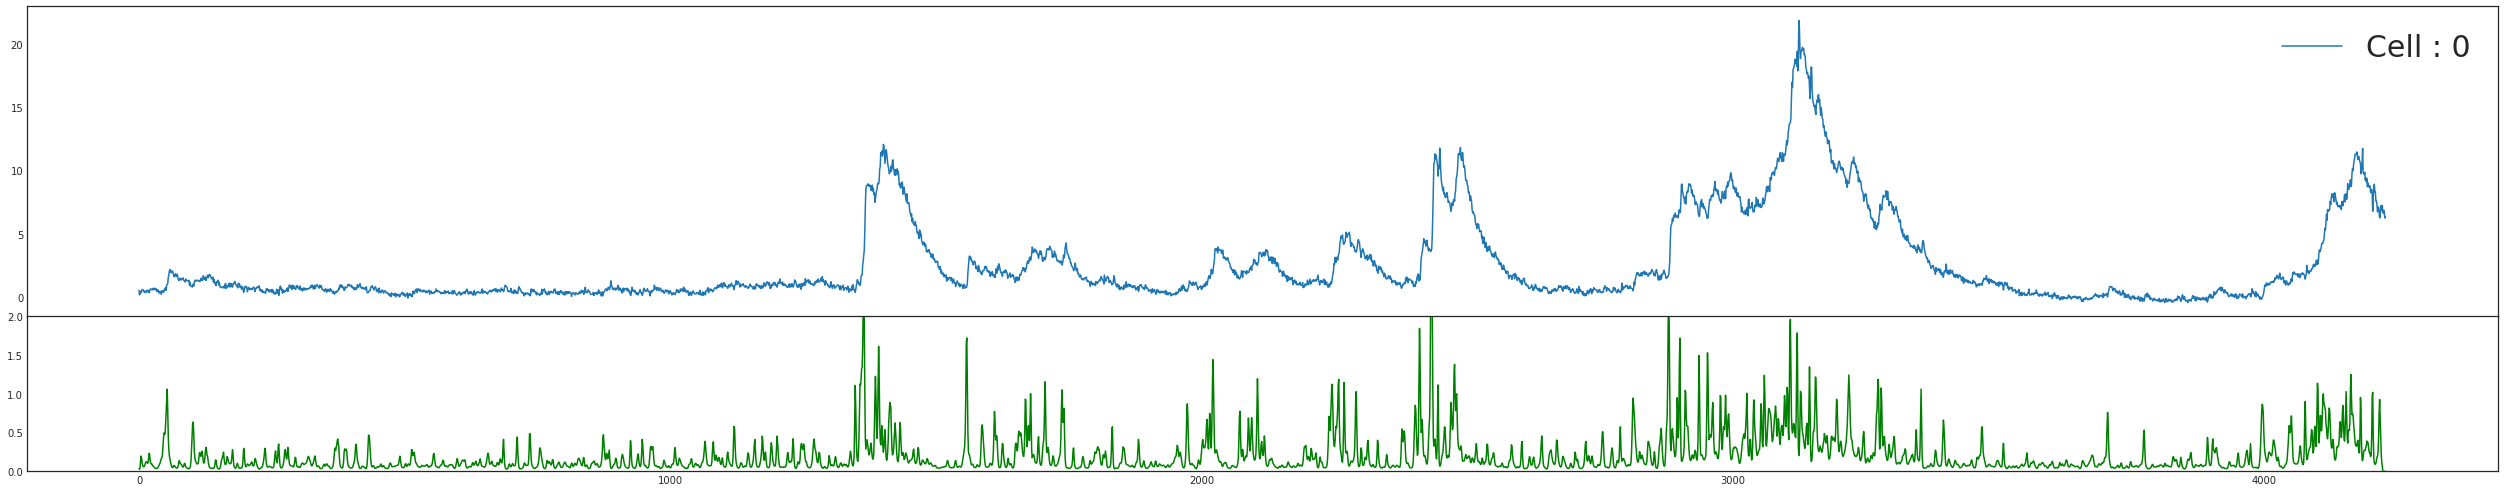

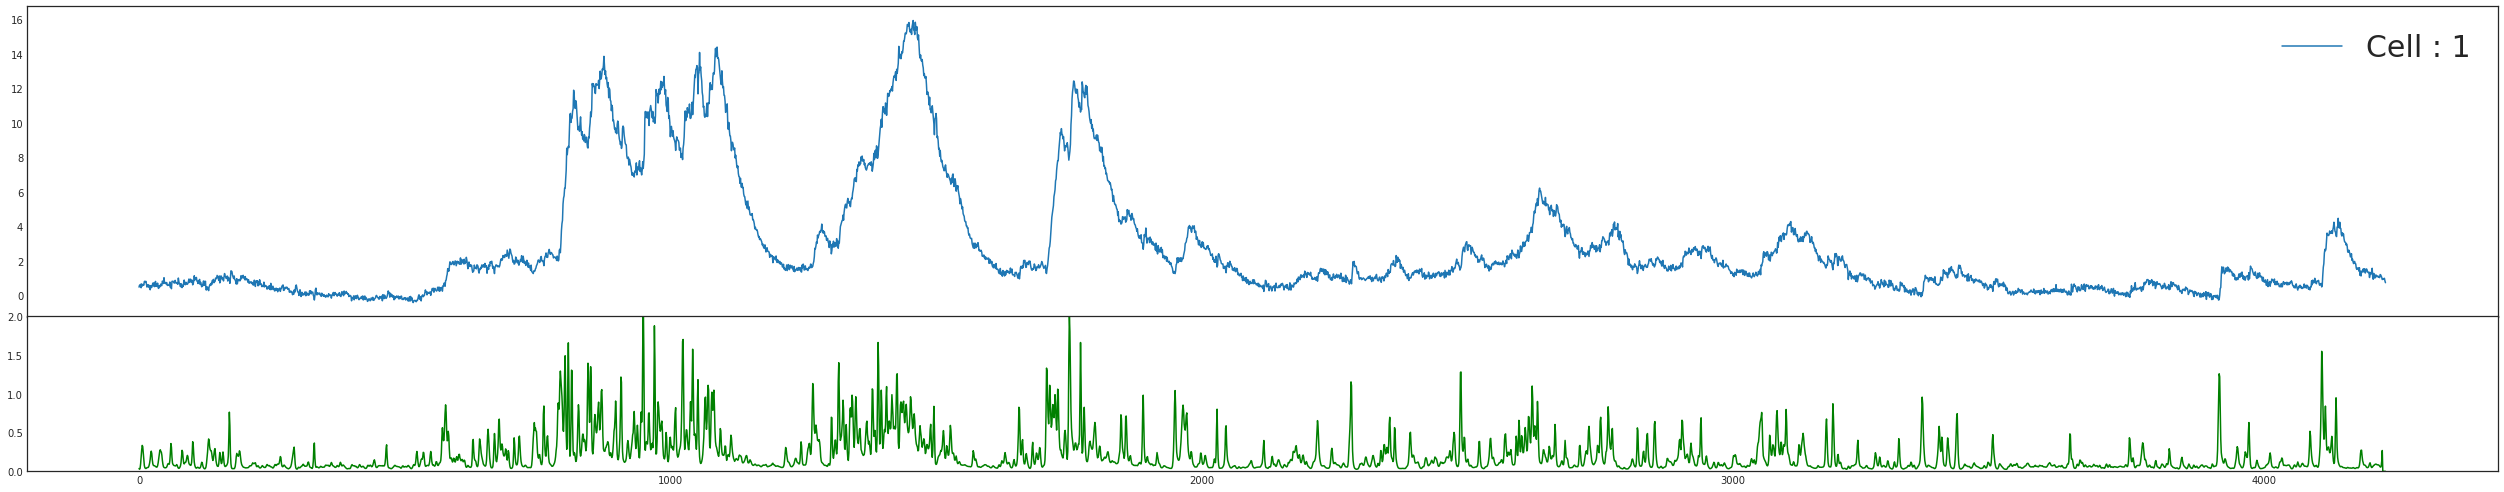

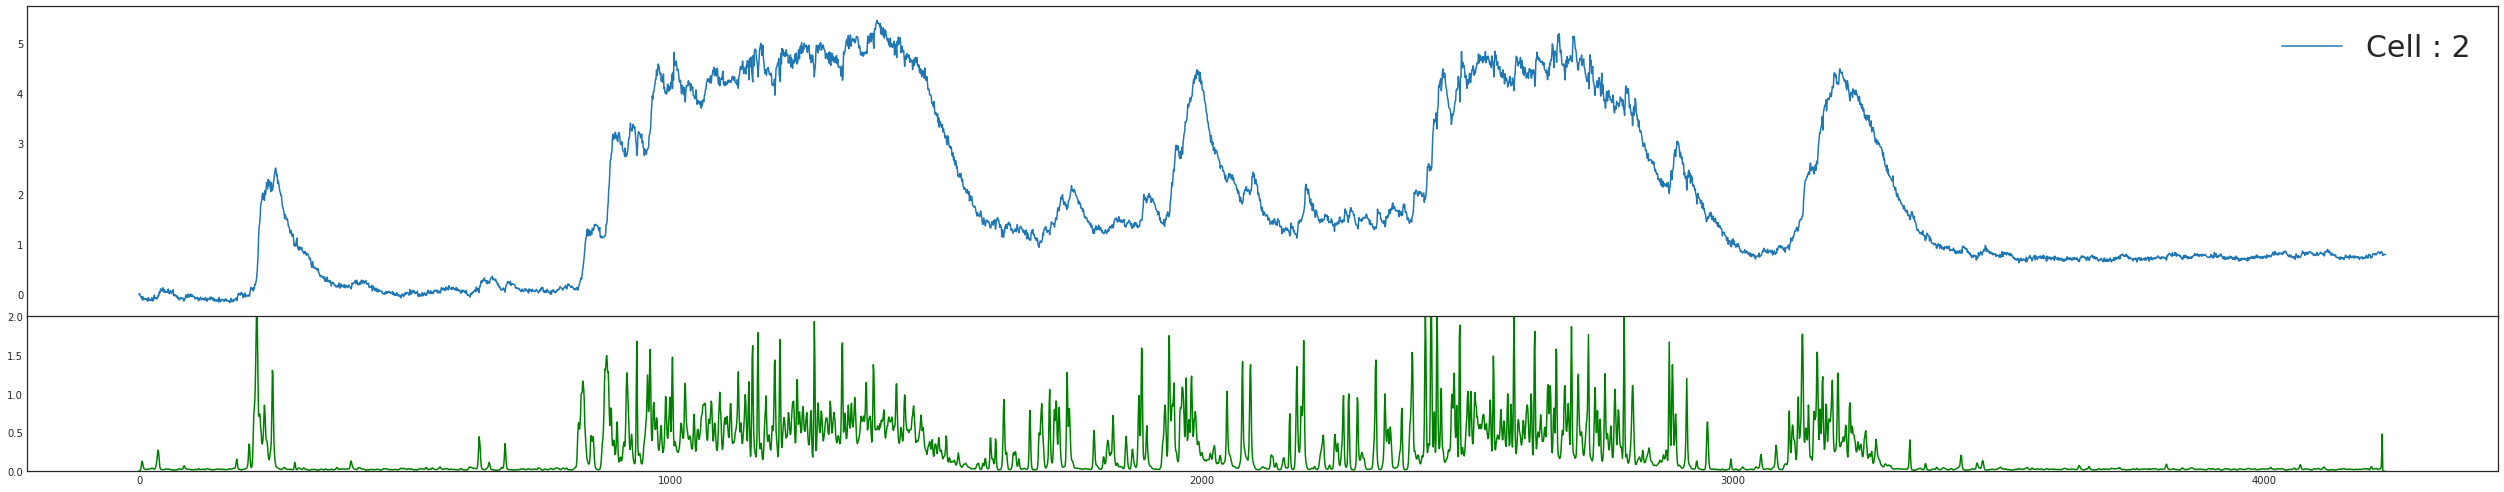

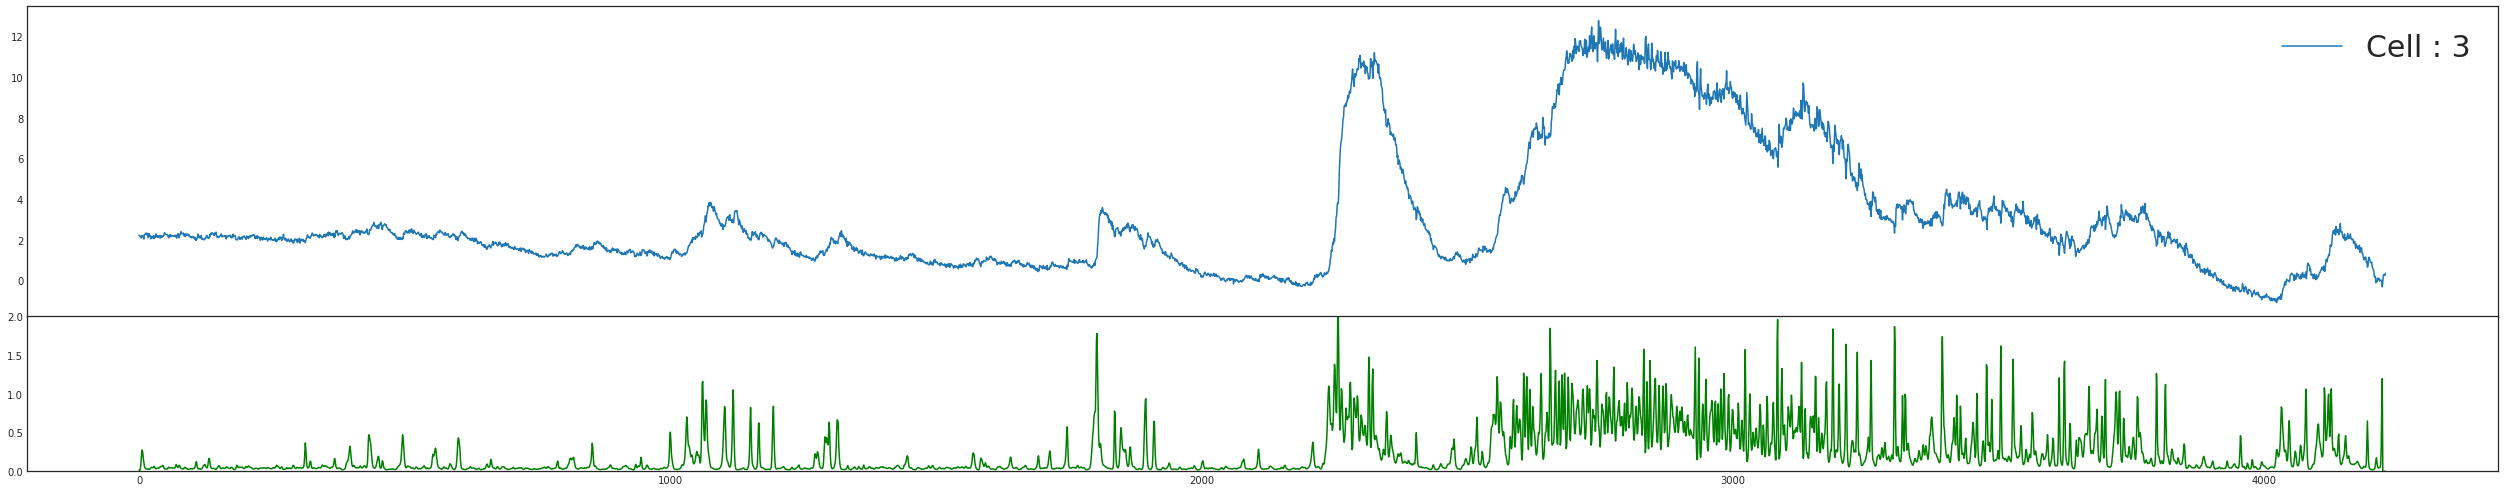

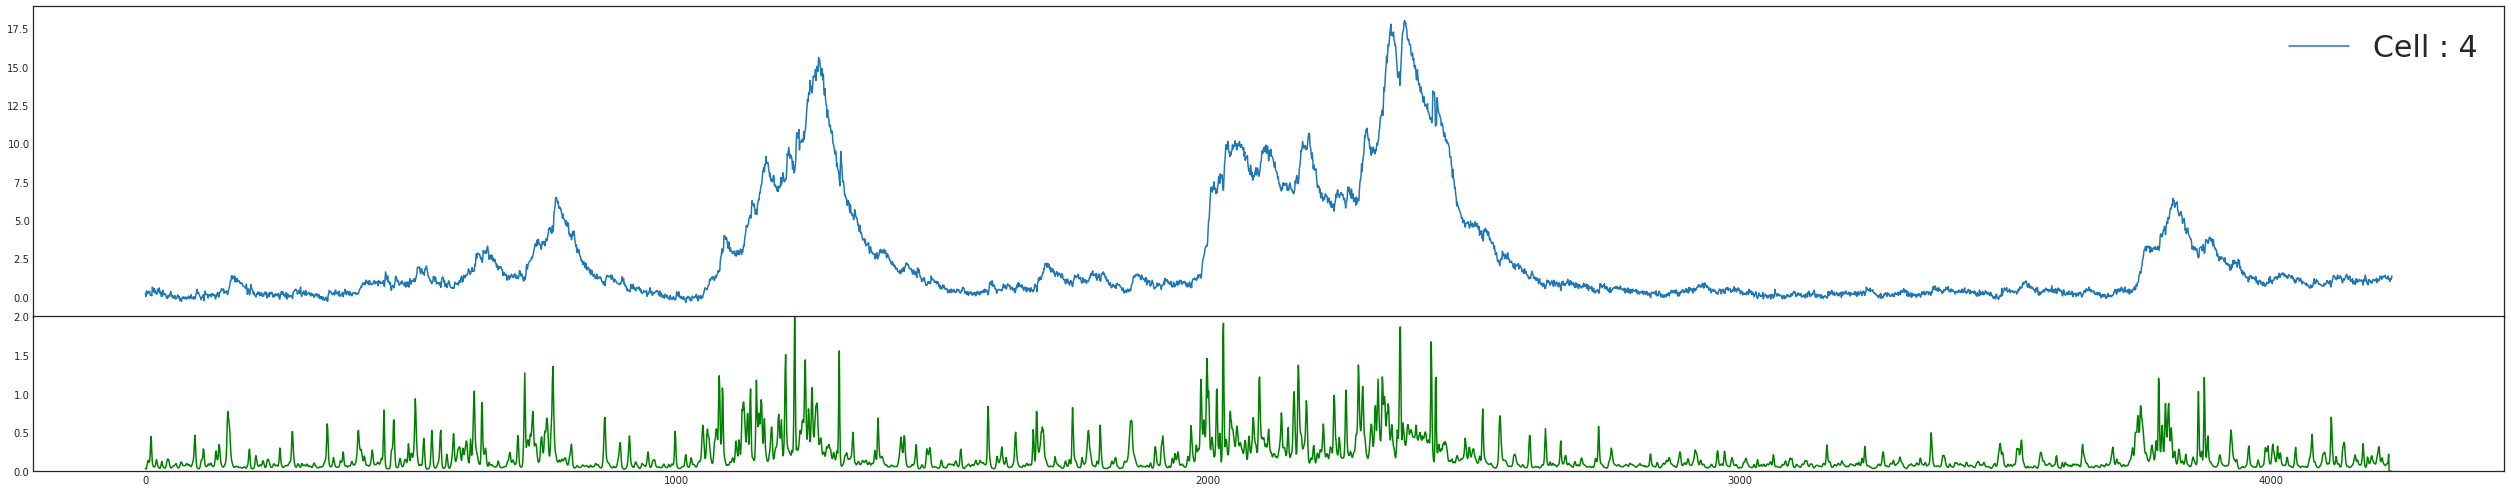

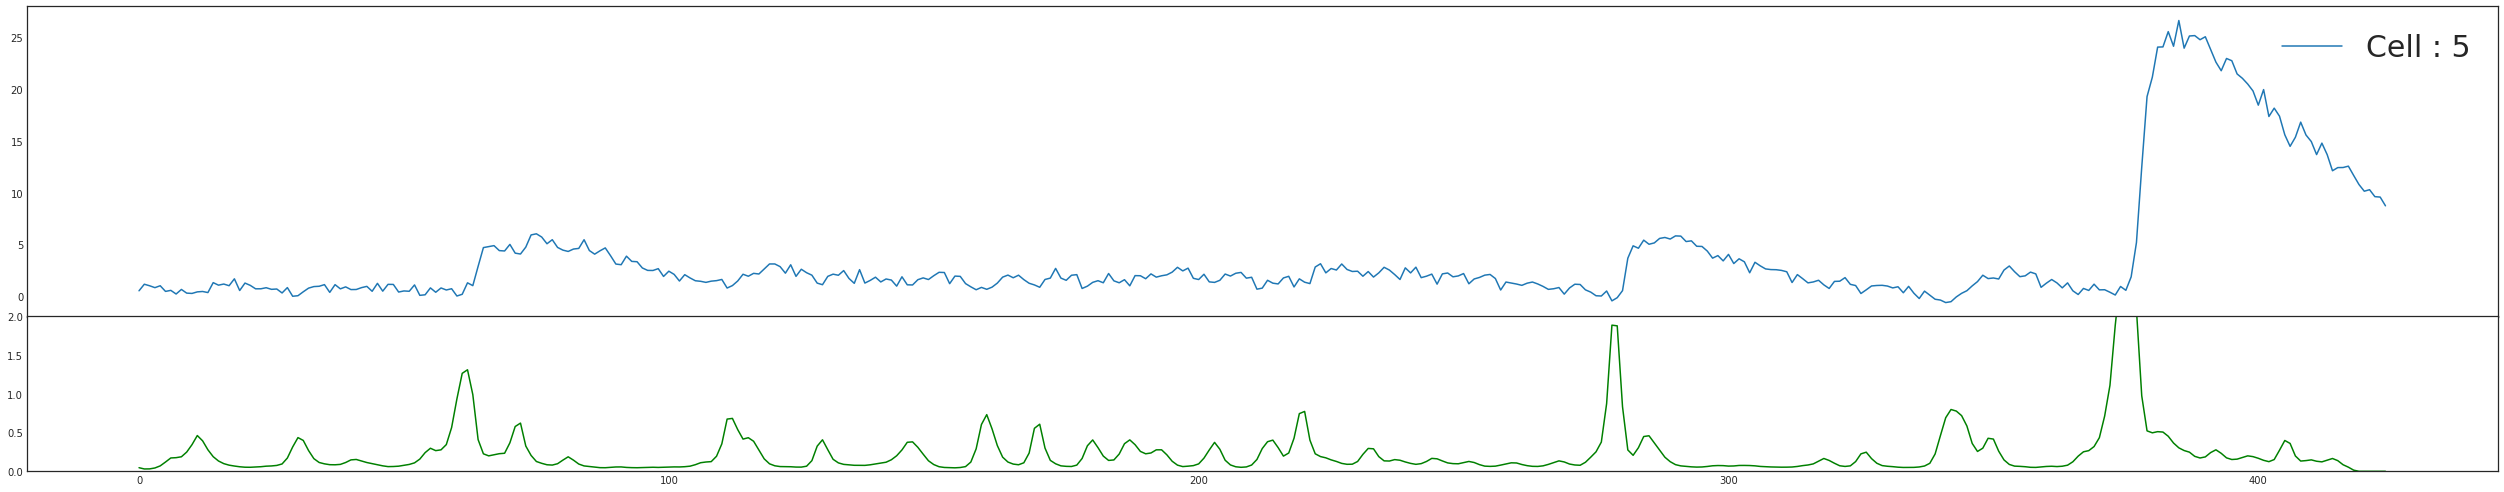

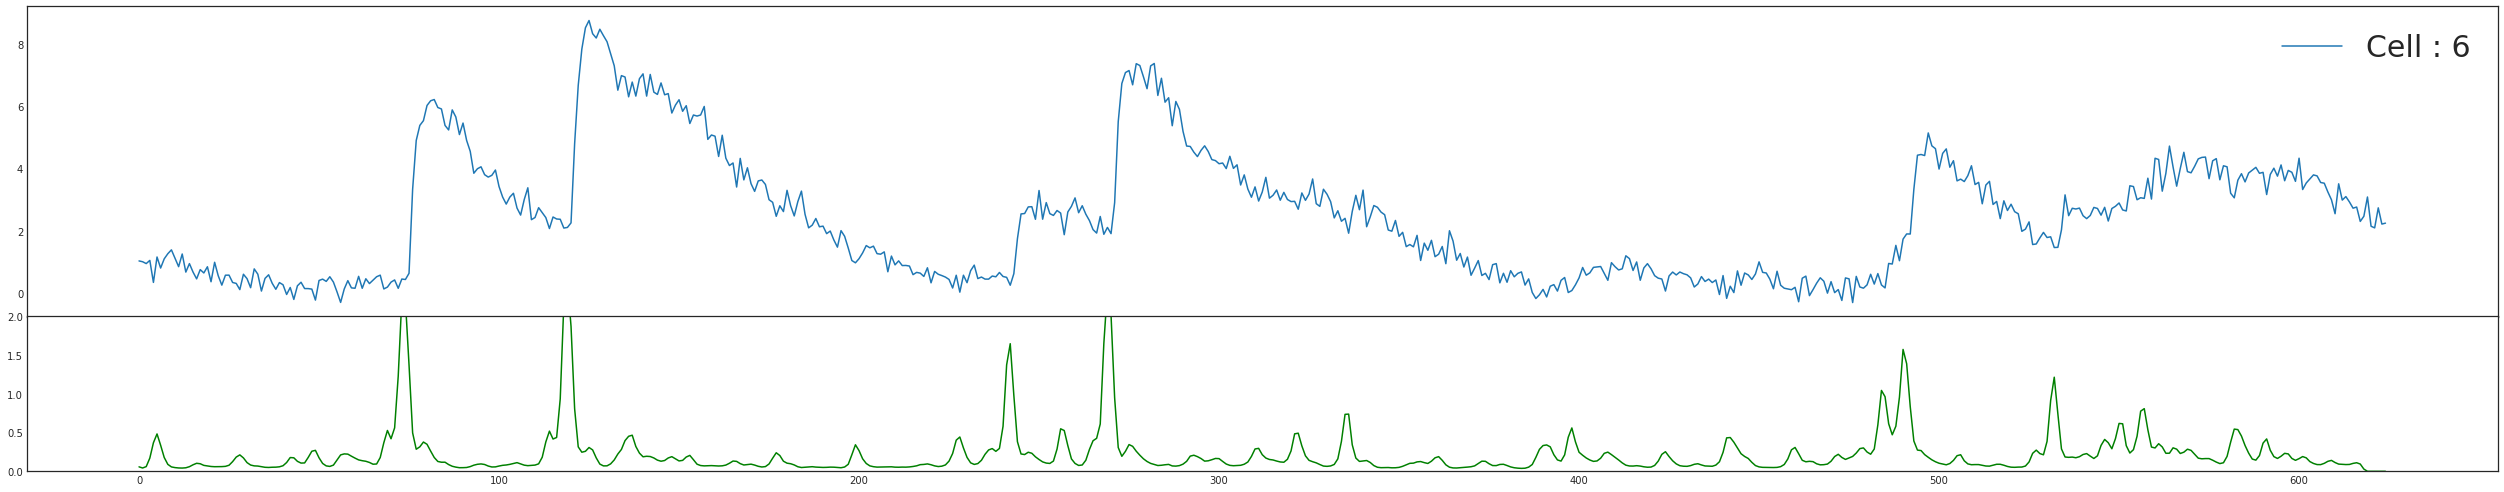

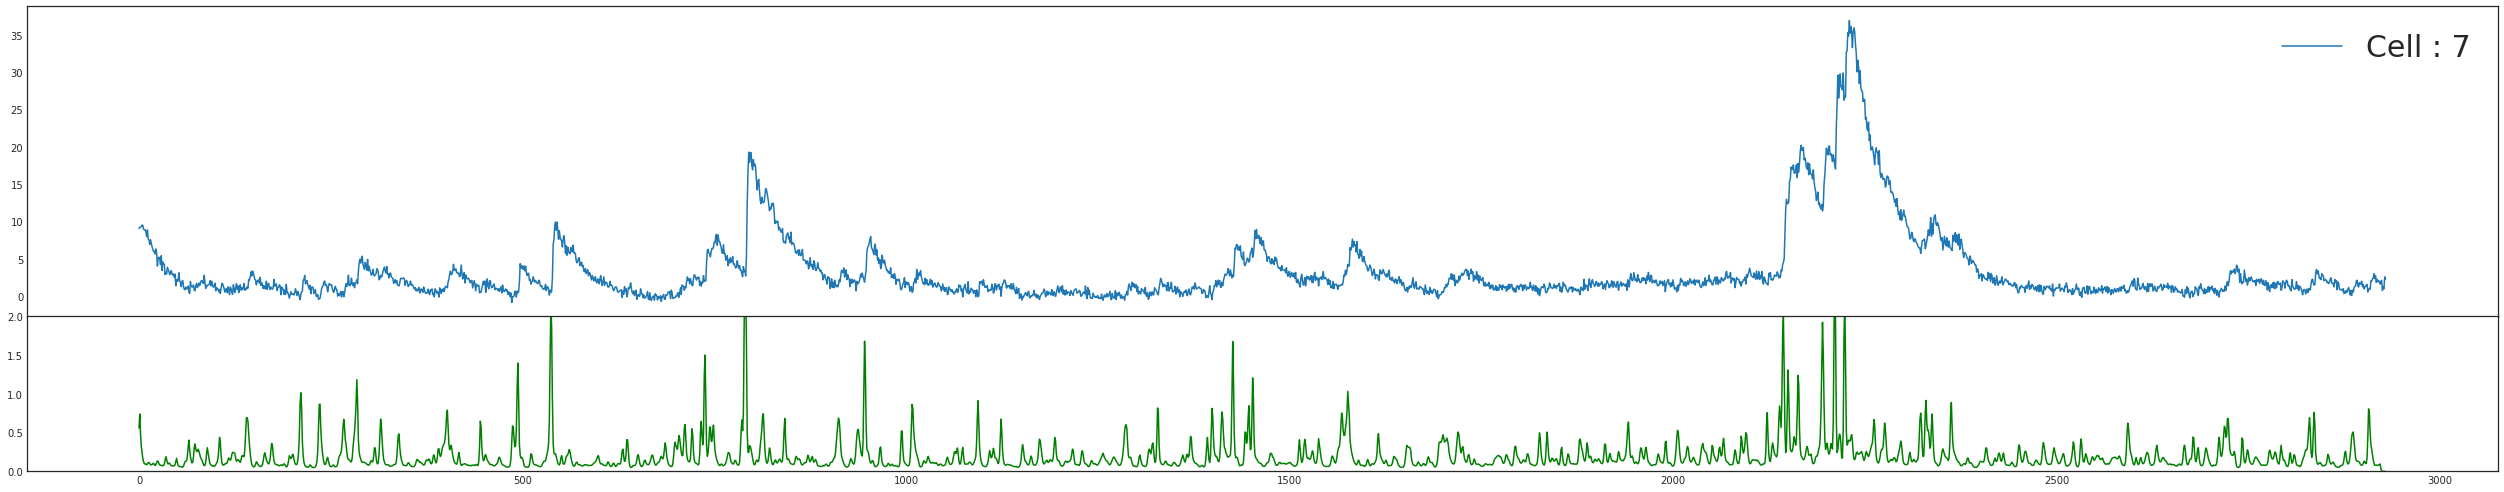

In [64]:
dset = 4

traces = calclist[dset]
preds = predlist[dset]

for i in range(len(traces.columns)):
    fig = plt.figure(figsize = (35,7))
    gs = gridspec.GridSpec(2, 1, height_ratios=([2, 1]))
    
    axes = []
    for j in range(2):
        axes.append(plt.Subplot(fig, gs[j]))
        fig.add_subplot(axes[j])
    gs.tight_layout(fig, h_pad=-1.8)
    axes[0].plot(rebin(np.array(traces[str(i)][:]),4)[0],label='Cell : '+str(i))
    axes[1].plot(rebin(np.array(preds[str(i)][:]),4)[0],'green')
    axes[1].set_ylim([0, 2])
    axes[0].legend(fontsize=30)
    fig.show()